In [1]:
from inference_utils import *
import numpy as np
import matplotlib.pyplot as plt
import io
from matplotlib.pyplot import figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from PIL import Image

In [2]:
import xml.etree.ElementTree as ET
annotation_dir = '/Users/rc/Documents/GitHub/my_patchcore/datasets/full_body/Annotations'
def getBBox(img_id):
    xml_filePath = os.path.join (annotation_dir, img_id + '.xml')
    xml_file = open(xml_filePath, encoding='UTF-8')
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    for obj in root.iter('object'):
        cls = obj.find('name').text
        bboxes = []
        if cls != 'HUMAN':
            xmlbox = obj.find('bndbox')
            xmin = int(xmlbox.find('xmin').text)
            xmax = int(xmlbox.find('xmax').text)
            ymin = int(xmlbox.find('ymin').text)
            ymax = int(xmlbox.find('ymax').text)
            single_box = {
                    'xmin':xmin,
                    'xmax':xmax,
                    'ymin':ymin,
                    'ymax':ymax,
            }
            bboxes.append(single_box)
    return bboxes

In [3]:
def renderFeatureMap(pxl_lvl_anom_score):
    score_range = pxl_lvl_anom_score.min(), pxl_lvl_anom_score.max()
    fmap_img = pred_to_img(pxl_lvl_anom_score, score_range)
    plt.imshow(fmap_img, cmap="jet", alpha=0.5)
    plt.axis('off')
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    overlay_img = Image.open(buf)
    return np.array(overlay_img)

In [4]:
def count_high(single_fmap):
    count = (single_fmap>=0.8).sum()
    return count

In [5]:
def selected_fmap (all_feature_images):
    energies = []
    for single_fmap in all_feature_images:
        energies.append(count_high(single_fmap))
        
    rank_list = [sorted(energies).index(x) for x in energies]

    final_weighted_list = []
    for r in rank_list:
        if r == 0:
            final_weighted_list.append(0.9)
        else:
            final_weighted_list.append(0.1/(len(rank_list)-1))
    print (final_weighted_list)
    
    average_fmap = []
    for idx, single_fmap in enumerate(all_feature_images):
        if len(average_fmap)==0:
            average_fmap = final_weighted_list[idx] * single_fmap
        else:
            average_fmap += final_weighted_list[idx] * single_fmap
            
    average_fmap = average_fmap/len(all_feature_images)
    return average_fmap

In [6]:
import random
import os

img_list = os.listdir('/Users/rc/Documents/GitHub/my_patchcore/datasets/full_body/test/objs/')
img_path = '/Users/rc/Documents/GitHub/my_patchcore/datasets/full_body/test/objs/' + random.choice(img_list)
info = None
if 'front' in img_path:
    info = 'front'
else:
    info = 'back'

model_dir = '/Users/rc/Documents/GitHub/my_patchcore/FrontBackCore/exp/2022_07_07_09_29_48/models'
average_pixel_score = []
all_feature_images = []
for single_model in os.listdir(model_dir):
    model_path = os.path.join(model_dir, single_model)
    results = InferenceCore(model_path).inference_one_img(img_path)
    all_feature_images.append(results['pixel_score'].numpy())

use cpu for training or inference
loading model dir: /Users/rc/Documents/GitHub/my_patchcore/FrontBackCore/exp/2022_07_07_09_29_48/models/MG9SY3ASH7B7_back sucessfully


/Users/rc/opt/anaconda3/envs/ind/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/Users/rc/opt/anaconda3/envs/ind/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


use cpu for training or inference
loading model dir: /Users/rc/Documents/GitHub/my_patchcore/FrontBackCore/exp/2022_07_07_09_29_48/models/6UCFYVHKJS2D_front sucessfully
use cpu for training or inference
loading model dir: /Users/rc/Documents/GitHub/my_patchcore/FrontBackCore/exp/2022_07_07_09_29_48/models/9EPQMUVDMJMA_front sucessfully
use cpu for training or inference
loading model dir: /Users/rc/Documents/GitHub/my_patchcore/FrontBackCore/exp/2022_07_07_09_29_48/models/W33BSUGSTTX3_front sucessfully
use cpu for training or inference
loading model dir: /Users/rc/Documents/GitHub/my_patchcore/FrontBackCore/exp/2022_07_07_09_29_48/models/FUDNA8V38827_back sucessfully
use cpu for training or inference
loading model dir: /Users/rc/Documents/GitHub/my_patchcore/FrontBackCore/exp/2022_07_07_09_29_48/models/45HSF27UKFA8_back sucessfully


[0.9, 0.02, 0.02, 0.02, 0.02, 0.02]


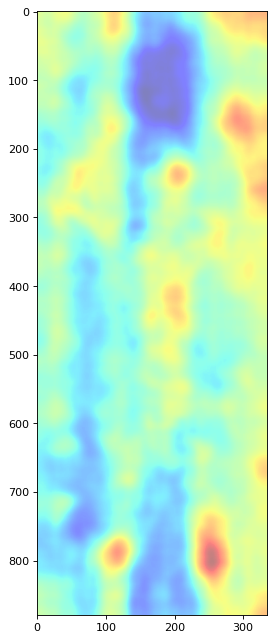

In [7]:
avg_fmap = selected_fmap(all_feature_images)
avg_fmap = torch.tensor(avg_fmap)
score_range = avg_fmap.min(), avg_fmap.max()
fmap_img = pred_to_img(avg_fmap, score_range)
figure(figsize=(10, 10), dpi=80)
plt.imshow(fmap_img, cmap="jet", alpha=0.5)

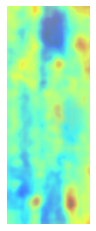

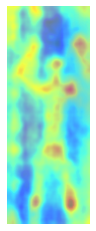

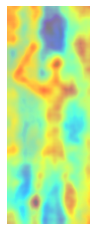

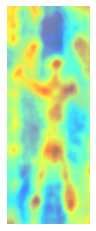

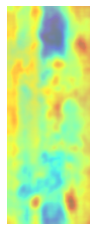

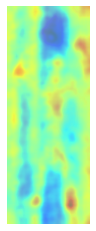

In [8]:
for fmap in all_feature_images:
    figure()
    fmap = torch.tensor(fmap)
    plt.imshow(renderFeatureMap(fmap))

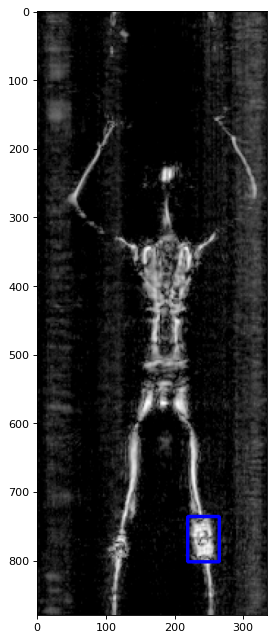

In [9]:
# sample_img = Image.open(img_path).convert('RGB')
sample_img = cv2.imread(img_path)
img_id = img_path.split('/')[-1].split('.jpg')[0]
all_boxes = getBBox(img_id)

for bb in all_boxes:
    image = cv2.rectangle(sample_img, (bb['xmin'], bb['ymin']), (bb['xmax'], bb['ymax']), (0, 0, 255), 3)

figure(figsize=(10, 10), dpi=80)
plt.imshow(image)